### 파일 옮기기

In [1]:
path_to_label = './data/gtFine/mask-only/'

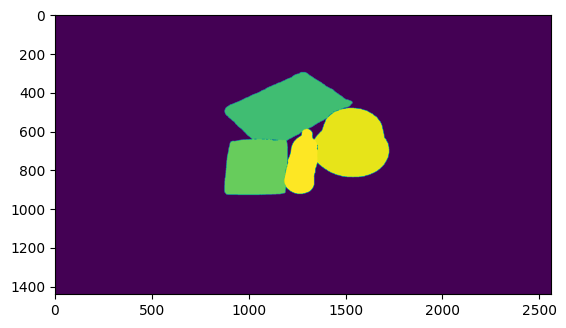

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
test = Image.open(path_to_label + '3_3_gtFine_labelIds.png')
plt.imshow(test)

In [17]:
import os
files = os.listdir(path_to_label)
files

['10_1_gtFine_color.png',
 '10_1_gtFine_instanceIds.png',
 '10_1_gtFine_labelIds.png',
 '10_2_gtFine_color.png',
 '10_2_gtFine_instanceIds.png',
 '10_2_gtFine_labelIds.png',
 '10_3_gtFine_color.png',
 '10_3_gtFine_instanceIds.png',
 '10_3_gtFine_labelIds.png',
 '11_1_gtFine_color.png',
 '11_1_gtFine_instanceIds.png',
 '11_1_gtFine_labelIds.png',
 '11_2_gtFine_color.png',
 '11_2_gtFine_instanceIds.png',
 '11_2_gtFine_labelIds.png',
 '11_3_gtFine_color.png',
 '11_3_gtFine_instanceIds.png',
 '11_3_gtFine_labelIds.png',
 '12_1_gtFine_color.png',
 '12_1_gtFine_instanceIds.png',
 '12_1_gtFine_labelIds.png',
 '12_2_gtFine_color.png',
 '12_2_gtFine_instanceIds.png',
 '12_2_gtFine_labelIds.png',
 '12_3_gtFine_color.png',
 '12_3_gtFine_instanceIds.png',
 '12_3_gtFine_labelIds.png',
 '13_2_gtFine_color.png',
 '13_2_gtFine_instanceIds.png',
 '13_2_gtFine_labelIds.png',
 '13_3_gtFine_color.png',
 '13_3_gtFine_instanceIds.png',
 '13_3_gtFine_labelIds.png',
 '14_1_gtFine_color.png',
 '14_1_gtFine_ins

In [19]:
import shutil
for file in files:
    if file.split('_')[-1] == 'labelIds.png':
        shutil.move(path_to_label + file, path_to_label + 'labels/' + file)

In [24]:
# 이름바꾸기
file_path = path_to_label + 'labels/'
labels = os.listdir(file_path)
for label in labels:
    src = os.path.join(file_path, label)
    name = label.split('_')
    dst = name[0] + '_' + name[1] + '.png'
    dst = os.path.join(file_path, dst)
    os.rename(src, dst)

### 데이터 확인

In [1]:
path_to_label = './data/gtFine/mask-only/labels/'
path_to_image = './data/imgsFine/leftImg8bit/mask-only/'

In [2]:
import glob
import torch
import numpy as np

from torch.utils.data.dataset import Dataset

from PIL import Image

import matplotlib.pyplot as plt

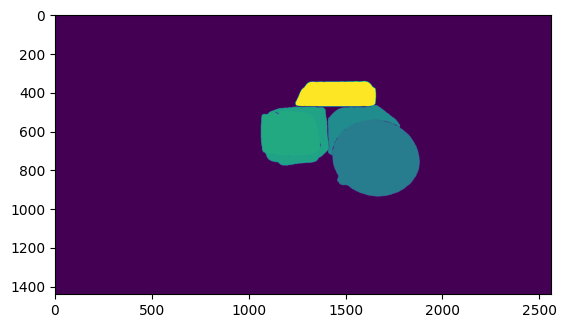

In [3]:
test = Image.open(path_to_label + '14_1.png')
plt.imshow(test)

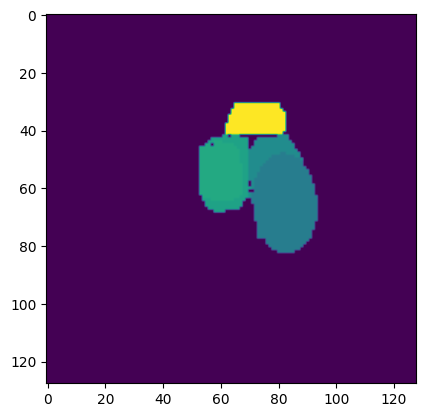

In [4]:
re = test.resize((128,128), Image.NEAREST)
plt.imshow(re)

In [5]:
a = np.array(re)
for i in range(100):
    if i in a:
        print(i)

0
14
16
19
20
33


In [3]:
class Garbage(Dataset):
    def __init__(self, path_to_image, path_to_label, train = True, transforms = None, input_size = (128, 128)):
        self.images = sorted(glob.glob(path_to_image+'*.png'))
        self.labels = sorted(glob.glob(path_to_label+'*.png'))
        
        self.X_train = list(filter(lambda x: x.split('_')[1][0] in ['1', '2'], self.images))
        self.X_test = list(filter(lambda x: x.split('_')[1][0] == '3', self.images))
        
        self.Y_train = list(filter(lambda x: x.split('_')[1][0] in ['1', '2'], self.labels))
        self.Y_test = list(filter(lambda x: x.split('_')[1][0] == '3', self.labels))
        
        self.train = train
        self.transforms = transforms
        self.input_size = input_size
        
    def __len__(self):
        if self.train:
            return len(self.X_train)
        else:
            return len(self.X_test)
        
    def preprocess_mask(self, mask):
        mask = mask.resize(self.input_size, Image.NEAREST)
        mask = np.array(mask).astype(np.float32)
        mask = torch.tensor(mask)
        return mask
    
    def __getitem__(self, i):
        if self.train:
            X_train = Image.open(self.X_train[i])
            X_train = self.transforms(X_train)
            Y_train = Image.open(self.Y_train[i])
            Y_train = self.preprocess_mask(Y_train)
            return X_train, Y_train
        else:
            X_test = Image.open(self.X_test[i])
            X_test = self.transforms(X_test)
            Y_test = Image.open(self.Y_test[i])
            Y_test = self.preprocess_mask(Y_test)
            return X_test, Y_test

In [4]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        
        self.enc1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.enc5_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        
        self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
        self.dec4_1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dec4_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        
        self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride=2)
        self.dec3_1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec3_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        
        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride=2)
        self.dec2_1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec2_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        
        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.dec1_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec1_3 = nn.Conv2d(64, num_classes, kernel_size=1)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.enc1_1(x)
        x = self.relu(x)
        e1 = self.enc1_2(x)
        e1 = self.relu(e1)
        x = self.pool1(e1)
            
        x = self.enc2_1(x)
        x = self.relu(x)
        e2 = self.enc2_2(x)
        e2 = self.relu(e2)
        x = self.pool2(e2)
            
        x = self.enc3_1(x)
        x = self.relu(x)
        e3 = self.enc3_2(x)
        e3 = self.relu(e3)
        x = self.pool3(e3)
            
        x = self.enc4_1(x)
        x = self.relu(x)
        e4 = self.enc4_2(x)
        e4 = self.relu(e4)
        x = self.pool4(e4)
            
        x = self.enc5_1(x)
        x = self.relu(x)
        x = self.enc5_2(x)
        x = self.relu(x)
            
        x = self.upsample4(x)
        x = torch.cat([x, e4], dim=1)
        x = self.dec4_1(x)
        x = self.relu(x)
        x = self.dec4_2(x)
        x = self.relu(x)
            
        x = self.upsample3(x)
        x = torch.cat([x, e3], dim=1)
        x = self.dec3_1(x)
        x = self.relu(x)
        x = self.dec3_2(x)
        x = self.relu(x)
            
        x = self.upsample2(x)
        x = torch.cat([x, e2], dim=1)
        x = self.dec2_1(x)
        x = self.relu(x)
        x = self.dec2_2(x)
        x = self.relu(x)
            
        x = self.upsample1(x)
        x = torch.cat([x, e1], dim=1)
        x = self.dec1_1(x)
        x = self.relu(x)
        x = self.dec1_2(x)
        x = self.relu(x)
        x = self.dec1_3(x)
        
        x = torch.squeeze(x)
                        
        return x

In [5]:
class UNet_256(UNet):
    def __init__(self, num_classes):
        super(UNet_256, self).__init__(num_classes)
        self.enc5_2 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc6_1 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1)
        self.enc6_2 = nn.Conv2d(2048, 1024, kernel_size=3, padding=1)
        
        self.upsample5 = nn.ConvTranspose2d(1024, 1024, 2, stride=2)
        self.dec5_1 = nn.Conv2d(2048, 1024, kernel_size=3, padding=1)
        self.dec5_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        
        
    def forward(self, x):
        x = self.enc1_1(x)
        x = self.relu(x)
        e1 = self.enc1_2(x)
        e1 = self.relu(e1)
        x = self.pool1(e1)
            
        x = self.enc2_1(x)
        x = self.relu(x)
        e2 = self.enc2_2(x)
        e2 = self.relu(e2)
        x = self.pool2(e2)
            
        x = self.enc3_1(x)
        x = self.relu(x)
        e3 = self.enc3_2(x)
        e3 = self.relu(e3)
        x = self.pool3(e3)
            
        x = self.enc4_1(x)
        x = self.relu(x)
        e4 = self.enc4_2(x)
        e4 = self.relu(e4)
        x = self.pool4(e4)
            
        x = self.enc5_1(x)
        x = self.relu(x)
        e5 = self.enc5_2(x)
        e5 = self.relu(e5)
        x = self.pool5(e5)
        
        x = self.enc6_1(x)
        x = self.relu(x)
        x = self.enc6_2(x)
        x = self.relu(x)
            
        x = self.upsample5(x)
        x = torch.cat([x, e5], dim=1)
        x = self.dec5_1(x)
        x = self.relu(x)
        x = self.dec5_2(x)
        x = self.relu(x)
        
        x = self.upsample4(x)
        x = torch.cat([x, e4], dim=1)
        x = self.dec4_1(x)
        x = self.relu(x)
        x = self.dec4_2(x)
        x = self.relu(x)
            
        x = self.upsample3(x)
        x = torch.cat([x, e3], dim=1)
        x = self.dec3_1(x)
        x = self.relu(x)
        x = self.dec3_2(x)
        x = self.relu(x)
            
        x = self.upsample2(x)
        x = torch.cat([x, e2], dim=1)
        x = self.dec2_1(x)
        x = self.relu(x)
        x = self.dec2_2(x)
        x = self.relu(x)
            
        x = self.upsample1(x)
        x = torch.cat([x, e1], dim=1)
        x = self.dec1_1(x)
        x = self.relu(x)
        x = self.dec1_2(x)
        x = self.relu(x)
        x = self.dec1_3(x)
        
        x = torch.squeeze(x)
                        
        return x

In [6]:
import tqdm

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor, Resize
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = Compose([
    Resize((256, 256)),
    ToTensor()
])

In [7]:
train_set = Garbage(path_to_image=path_to_image, path_to_label=path_to_label, transforms=transform, input_size=(256, 256))
test_set = Garbage(path_to_image=path_to_image, path_to_label=path_to_label, transforms=transform, input_size=(256,256), train=False)

train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
test_loader = DataLoader(test_set)

In [8]:
model = UNet_256(num_classes=34).to(device)
learning_rate = 0.0001
optim = Adam(params=model.parameters(), lr=learning_rate)

## Default Cross Entropy: 256*256

In [15]:
for epoch in range(100):
    iterator = tqdm.tqdm(train_loader)
    
    for data, label in iterator:
        optim.zero_grad()
        
        preds = model(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.long().to(device))
        loss.backward()
        
        optim.step()
        
        iterator.set_description(f'epoch{epoch+1} loss:{loss.item()}')
        
torch.save(model.state_dict(), './UNet_256.pth')

epoch100 loss:0.12786254286766052: 100%|███████████████████████████████████████████████| 15/15 [00:05<00:00,  2.70it/s]


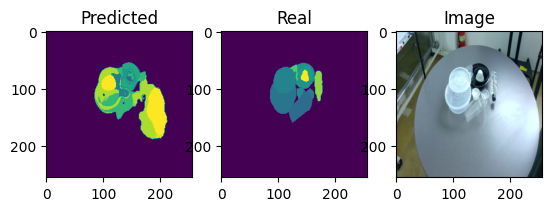

Predicted: [0, 11, 12, 14, 16, 18, 19, 20, 21, 22, 24, 25, 26, 29, 33]
Real: [0, 11, 12, 13, 14, 15, 16, 17, 23, 26, 31]

Recall: 0.5454545454545454
Precision: 0.4


In [38]:
import matplotlib.pyplot as plt

model.load_state_dict(torch.load('./UNet_256.pth'))
data, label = test_set[0]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

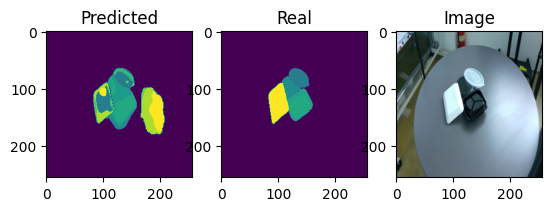

Predicted: [0, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 29, 33]
Real: [0, 14, 16, 19, 20, 33]

Recall: 1.0
Precision: 0.375


In [40]:
model.load_state_dict(torch.load('./UNet_256.pth'))
data, label = test_set[3]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

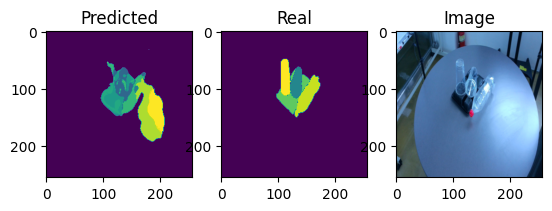

Predicted: [0, 11, 12, 14, 16, 18, 19, 20, 21, 22, 26, 29, 33]
Real: [0, 11, 18, 22, 24]

Recall: 0.8
Precision: 0.3076923076923077


In [41]:
model.load_state_dict(torch.load('./UNet_256.pth'))
data, label = test_set[4]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

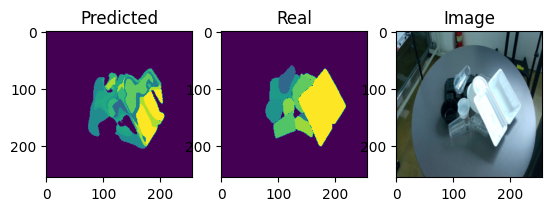

Predicted: [0, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 29, 33]
Real: [0, 11, 13, 17, 18, 24, 25, 26, 27, 28, 33]

Recall: 0.7272727272727273
Precision: 0.5


In [44]:
model.load_state_dict(torch.load('./UNet_256.pth'))
data, label = test_set[7]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

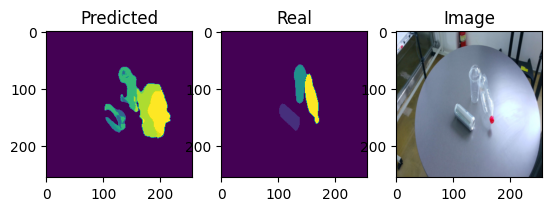

Predicted: [0, 11, 16, 19, 20, 21, 22, 26, 29, 33]
Real: [0, 3, 11, 22]

Recall: 0.75
Precision: 0.3


In [47]:
model.load_state_dict(torch.load('./UNet_256.pth'))
data, label = test_set[10]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

## Focal Loss: 256*256

In [22]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss()
        
    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [16]:
for epoch in range(100):
    iterator = tqdm.tqdm(train_loader)
    
    for data, label in iterator:
        optim.zero_grad()
        
        preds = model(data.to(device))
        loss = FocalLoss()(preds, label.long().to(device))
        loss.backward()
        
        optim.step()
        
        iterator.set_description(f'epoch{epoch+1} loss:{loss.item()}')
        
torch.save(model.state_dict(), './UNet_FocalLoss_256.pth')

epoch71 loss:0.04518752545118332: 100%|████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.68it/s]


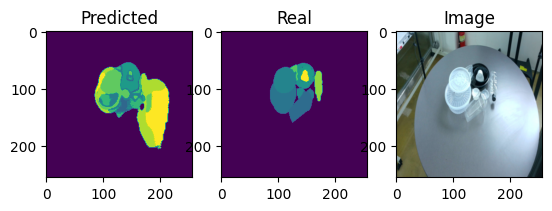

Predicted: [0, 11, 14, 18, 22, 25, 26, 29, 33]
Real: [0, 11, 12, 13, 14, 15, 16, 17, 23, 26, 31]

Recall: 0.36363636363636365
Precision: 0.4444444444444444


In [10]:
model.load_state_dict(torch.load('./UNet_FocalLoss_256.pth'))
data, label = test_set[0]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

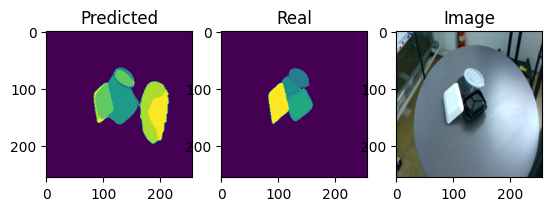

Predicted: [0, 11, 12, 14, 18, 22, 25, 26, 29, 33]
Real: [0, 14, 16, 19, 20, 33]

Recall: 0.5
Precision: 0.3


In [11]:
model.load_state_dict(torch.load('./UNet_FocalLoss_256.pth'))
data, label = test_set[3]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

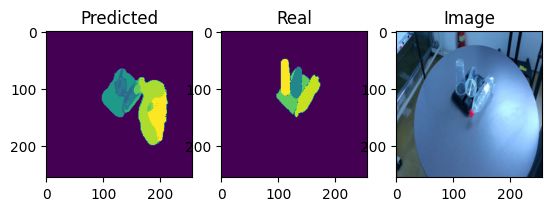

Predicted: [0, 11, 14, 18, 22, 25, 26, 29, 33]
Real: [0, 11, 18, 22, 24]

Recall: 0.8
Precision: 0.4444444444444444


In [12]:
model.load_state_dict(torch.load('./UNet_FocalLoss_256.pth'))
data, label = test_set[4]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

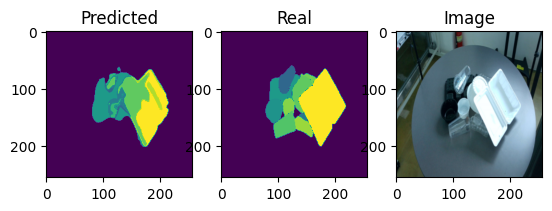

Predicted: [0, 11, 14, 18, 19, 22, 25, 26, 29, 33]
Real: [0, 11, 13, 17, 18, 24, 25, 26, 27, 28, 33]

Recall: 0.5454545454545454
Precision: 0.6


In [13]:
model.load_state_dict(torch.load('./UNet_FocalLoss_256.pth'))
data, label = test_set[7]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

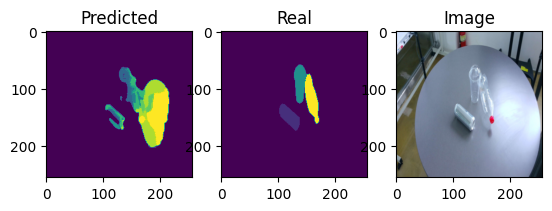

Predicted: [0, 11, 14, 18, 22, 25, 26, 29, 33]
Real: [0, 3, 11, 22]

Recall: 0.75
Precision: 0.3333333333333333


In [14]:
model.load_state_dict(torch.load('./UNet_FocalLoss_256.pth'))
data, label = test_set[10]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

## Default Cross Entropy: 128*128

In [15]:
transform = Compose([
    Resize((128, 128)),
    ToTensor()
])

train_set = Garbage(path_to_image=path_to_image, path_to_label=path_to_label, transforms=transform)
test_set = Garbage(path_to_image=path_to_image, path_to_label=path_to_label, transforms=transform, train=False)

train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
test_loader = DataLoader(test_set)

model = UNet(num_classes=34).to(device)
learning_rate = 0.0001
optim = Adam(params=model.parameters(), lr=learning_rate)

In [16]:
for epoch in range(100):
    iterator = tqdm.tqdm(train_loader)
    
    for data, label in iterator:
        optim.zero_grad()
        
        preds = model(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.long().to(device))
        loss.backward()
        
        optim.step()
        
        iterator.set_description(f'epoch{epoch+1} loss:{loss.item()}')
        
torch.save(model.state_dict(), './UNet.pth')

epoch100 loss:0.28031283617019653: 100%|███████████████████████████████████████████████| 15/15 [00:04<00:00,  3.50it/s]


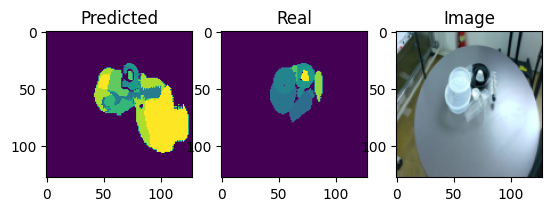

Predicted: [0, 12, 14, 16, 17, 18, 22, 25, 26, 29, 33]
Real: [0, 11, 12, 13, 14, 15, 16, 17, 23, 26, 31]

Recall: 0.5454545454545454
Precision: 0.5454545454545454


In [17]:
import matplotlib.pyplot as plt

model.load_state_dict(torch.load('./UNet.pth'))
data, label = test_set[0]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

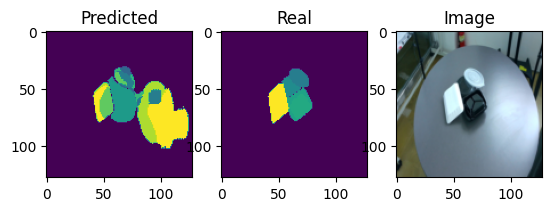

Predicted: [0, 9, 11, 12, 14, 16, 17, 18, 22, 25, 26, 29, 33]
Real: [0, 14, 16, 19, 20, 33]

Recall: 0.6666666666666666
Precision: 0.3076923076923077


In [18]:
model.load_state_dict(torch.load('./UNet.pth'))
data, label = test_set[3]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

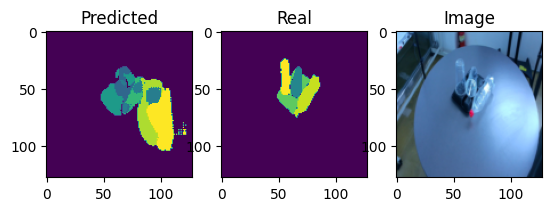

Predicted: [0, 11, 12, 14, 16, 18, 22, 29, 33]
Real: [0, 11, 18, 22, 24]

Recall: 0.8
Precision: 0.4444444444444444


In [19]:
model.load_state_dict(torch.load('./UNet.pth'))
data, label = test_set[4]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

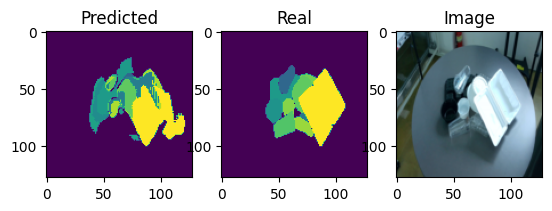

Predicted: [0, 2, 11, 12, 14, 16, 17, 18, 19, 20, 22, 25, 26, 29, 33]
Real: [0, 11, 13, 17, 18, 24, 25, 26, 27, 28, 33]

Recall: 0.6363636363636364
Precision: 0.4666666666666667


In [20]:
model.load_state_dict(torch.load('./UNet.pth'))
data, label = test_set[7]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

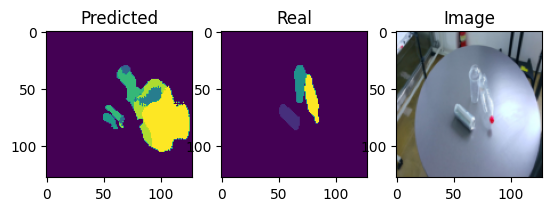

Predicted: [0, 2, 11, 12, 14, 18, 19, 22, 26, 29, 33]
Real: [0, 3, 11, 22]

Recall: 0.75
Precision: 0.2727272727272727


In [21]:
model.load_state_dict(torch.load('./UNet.pth'))
data, label = test_set[10]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

## Focal Loss: 128*128

In [24]:
for epoch in range(100):
    iterator = tqdm.tqdm(train_loader)
    
    for data, label in iterator:
        optim.zero_grad()
        
        preds = model(data.to(device))
        loss = FocalLoss()(preds, label.long().to(device))
        loss.backward()
        
        optim.step()
        
        iterator.set_description(f'epoch{epoch+1} loss:{loss.item()}')
        
torch.save(model.state_dict(), './UNet_FocalLoss.pth')

epoch100 loss:0.00879641529172659: 100%|███████████████████████████████████████████████| 15/15 [00:04<00:00,  3.71it/s]


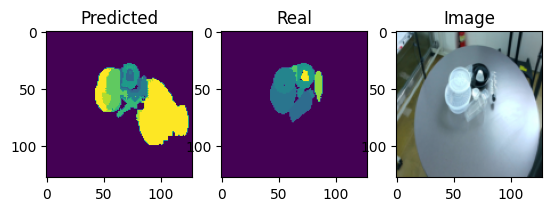

Predicted: [0, 11, 12, 14, 18, 20, 22, 25, 29, 33]
Real: [0, 11, 12, 13, 14, 15, 16, 17, 23, 26, 31]

Recall: 0.36363636363636365
Precision: 0.4


In [28]:
import matplotlib.pyplot as plt

model.load_state_dict(torch.load('./UNet_FocalLoss.pth'))
data, label = test_set[0]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

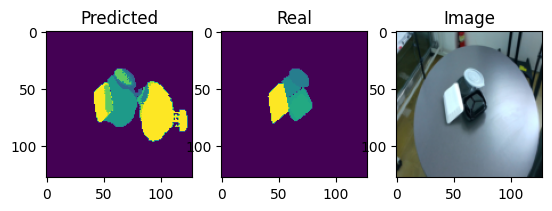

Predicted: [0, 11, 12, 14, 16, 18, 19, 22, 25, 29, 33]
Real: [0, 14, 16, 19, 20, 33]

Recall: 0.8333333333333334
Precision: 0.45454545454545453


In [29]:
import matplotlib.pyplot as plt

model.load_state_dict(torch.load('./UNet_FocalLoss.pth'))
data, label = test_set[3]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

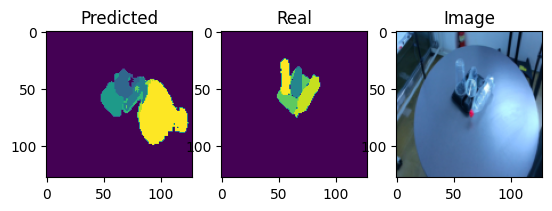

Predicted: [0, 11, 12, 14, 18, 22, 25, 29, 33]
Real: [0, 11, 18, 22, 24]

Recall: 0.8
Precision: 0.4444444444444444


In [30]:
import matplotlib.pyplot as plt

model.load_state_dict(torch.load('./UNet_FocalLoss.pth'))
data, label = test_set[4]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()
    
pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

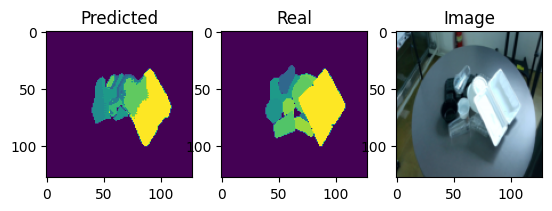

Predicted: [0, 11, 12, 14, 16, 18, 22, 25, 29, 33]
Real: [0, 11, 13, 17, 18, 24, 25, 26, 27, 28, 33]

Recall: 0.45454545454545453
Precision: 0.5


In [31]:
model.load_state_dict(torch.load('./UNet_FocalLoss.pth'))
data, label = test_set[7]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))

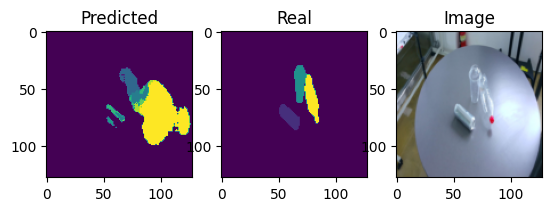

Predicted: [0, 11, 12, 14, 18, 22, 25, 29, 33]
Real: [0, 3, 11, 22]

Recall: 0.75
Precision: 0.3333333333333333


In [32]:
model.load_state_dict(torch.load('./UNet_FocalLoss.pth'))
data, label = test_set[10]
pred = model(torch.unsqueeze(data.to(device), dim=0))

pred = torch.argmax(pred, dim=0)

with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,3,2)
    plt.title('Real')
    plt.imshow(label)
    image = data.permute(1, 2, 0).numpy()
    plt.subplot(1,3,3)
    plt.title('Image')
    plt.imshow(image)
    plt.show()

pred_list = []
with torch.no_grad():
    for i in range(100):
        if i in np.array(pred.cpu()) and i not in pred_list:
            pred_list.append(i)
print('Predicted:', pred_list)
            
label_list = []
for i in range(100):
    if i in np.array(label) and i not in label_list:
        label_list.append(i)
print('Real:', label_list)
print()
correct = len(set(pred_list).intersection(set(label_list)))
print('Recall:', correct/len(label_list))
print('Precision:', correct/len(pred_list))